# Differential Dynamic Microscopy analysis

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2

In [2]:
# Import microscope video file
filename = '/Users/tkchiang/Downloads/data.avi'

video_capture = cv2.VideoCapture(filename)
frames = []
while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break
    frames.append(frame)
frames_array = np.array(frames)
video_capture.release()

f = np.sum(frames,axis=3)

## User-input parameters
PixelSize = 0.20 # Pixel size in microns, measured using stage micrometer
FrameTime = 1.00 # Frame time in milliseconds

In [3]:
images = np.array(f,'float')
Nframes = images.shape[0]
Npixels = images.shape[1]

### Step 1: Generate difference images and calculate their Fourier transforms

We have a video of particles diffusing, $I(x,y, t)$. Below is shown the first frame of the video:

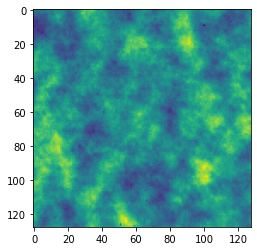

In [4]:
im1 = images[0] # First image in video
plt.imshow(im1)

The intensity at each point in the image, $I(x,y,0)$, represents the light detected at each pixel on the camera, which is a result of background illumination, camera noise, as well as scattering from the particles in the sample chamber.

Since we care only about the scattering from the moving particles, and because the background and noise is relatively static, we take the difference between frames in the video that are separated by time lags.

Below is shown the result of subtracting the first frame shown above from the eleventh frame, $D(x,y ; \Delta t = 10) = I(x,y,11) - I(x,y,1)$:

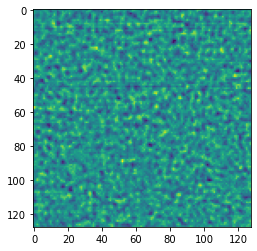

In [5]:
im2 = images[9] # 10th image in video
diffim = im2 - im1
plt.imshow(diffim)

The resulting pattern of spatial fluctuations are a consequence of the motion of the particles, and the spatial and temporal characteristics of the pattern are dependent on the type of motion. In this case, we are looking at particles exhibiting Brownian motion.

In multi-angle dynamic light scattering (DLS), fluctuations in the intensity of scattered coherent light are also a result of the motion of the particles in solution. These intensity traces are measured at many different scattered wave vectors $q$ by changing the angle $\theta$ at which the detector is placed:

$$ q = \frac{4\pi}{\lambda} \sin\theta $$

In DDM analysis, we perform an equivalent measurement by Fourier analysis of the difference images.

In [6]:
# q values
Q = 2*np.pi/(Npixels*PixelSize)*np.linspace(1,int(Npixels/2),int(Npixels/2))

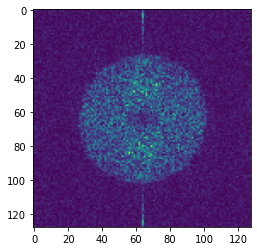

In [7]:
imf = np.fft.fftshift(np.abs(np.fft.fft2(diffim)))
plt.imshow(imf,vmin=0, vmax=np.max(imf))

The Fourier transform of the real-space difference image is shown above. A Fourier component of the microscope image is associated with a scattered wave vector, which represents some spatial frequency. Because the motion of the particles is isotropic, the resulting fluctuation pattern in the difference images gives a symmetric distribution of spatial frequencies, and the Fourier image appears as a radially symmetric "donut" with peak intensity at some wave number $|\bar{q}|$.

To get better statistics, the Fourier images are calculated over many difference images that are separated by the same lag-time. We generate many Fourier images using log-spaced lag-times.

In [8]:
# This function generates log-spaced integer-value frame lags.
# https://stackoverflow.com/questions/12418234/logarithmically-spaced-integers
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x), result)), dtype=np.uint64)

In [9]:
# This function computes the time-averaged Fourier transforms of difference images.
def get_FT_ims(images, numPairs, lags):
    fftims0 = []
    for lag in lags:
        imf = 0
        # Linearly spaced frame times at which we calculate difference images
        frames = np.linspace(lag, numImages, num=numPairs, dtype=int)
        
        # Averaging over all difference images
        for t in frames:
            im1 = images[t] # Frame 1
            im1 = im1/np.sum(im1) # Normalize intensity of first image
            im2 = images[int(t-lag)] # Frame 2
            im2 = im2/np.sum(im2) # Normalize intensity of second image
            diffIm = im1 - im2 # Difference image
            
            # Fourier transform difference image and
            imf += np.fft.fftshift(np.abs(np.fft.fft2(diffIm))**2)/numPairs
            
        fftims0.append(imf)
        
    return fftims0

In [10]:
# Log-spaced frame lags
numImages = Nframes-1
numLags = 50
lags = gen_log_space(numImages,numLags)

# Get time lags in milliseconds
dT = lags*FrameTime

# Number of difference images to average over.
# A larger number gives better statistics but takes longer to compute.
numPairs = 100

In [11]:
# Get unprocessed FT difference images
fftims0 = get_FT_ims(images, numPairs, lags)

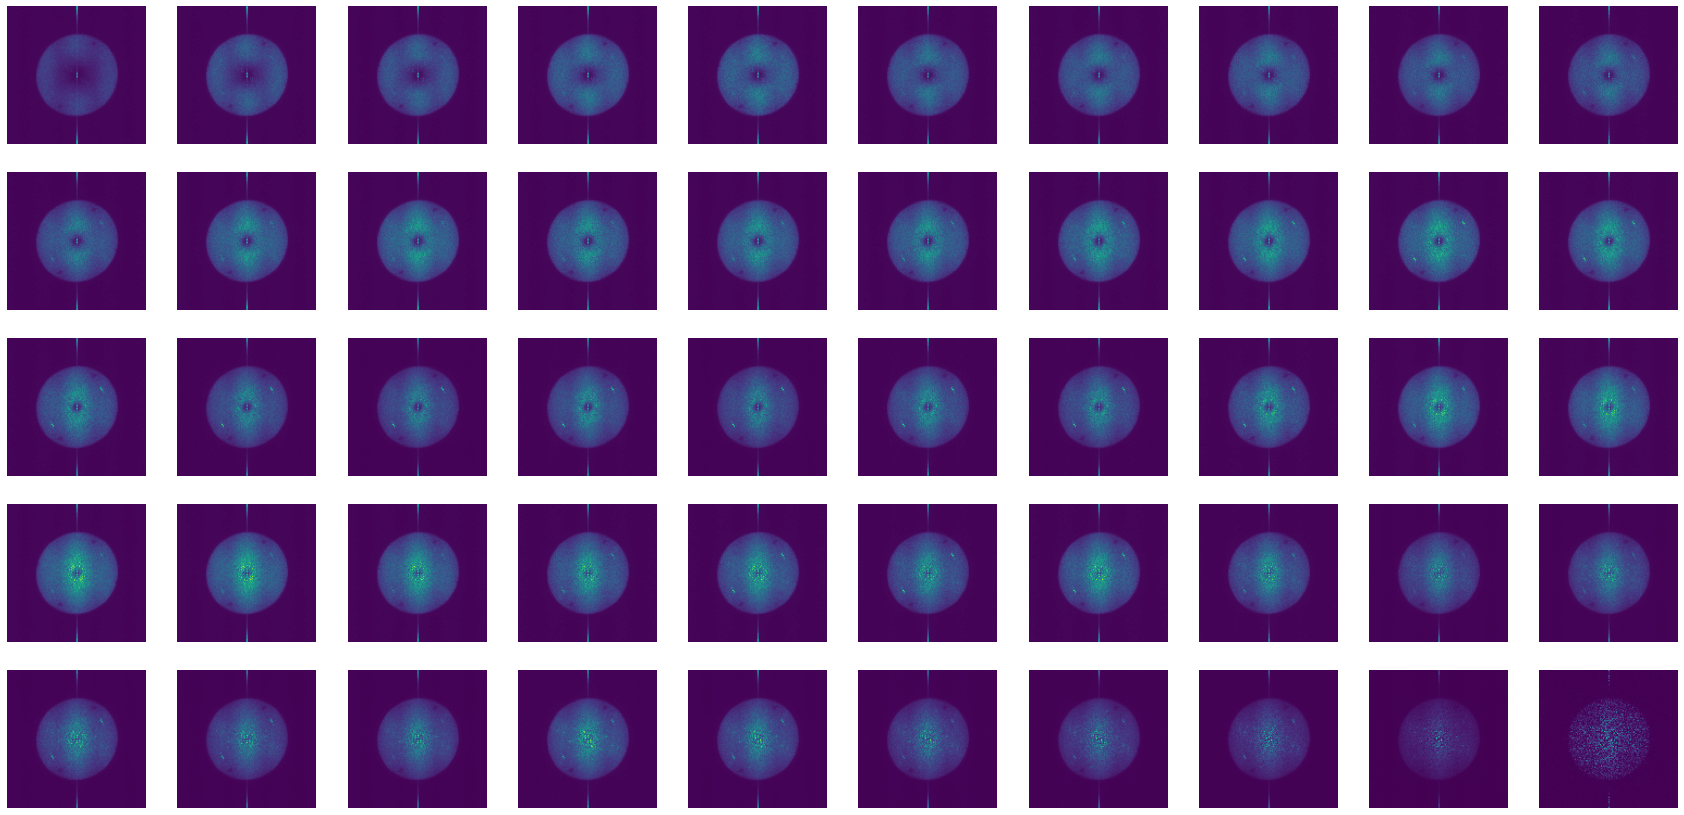

In [12]:
# Plot unprocessed Fourier images. 
# Note the vertical or horizontal bright stripes through the center due to camera artifacts.
fig = plt.figure(figsize=(30,30))
rows = 10
cols = 10
for im in range(len(fftims0)):
    fig.add_subplot(rows, cols, im+1)
    plt.imshow(fftims0[im],vmin=0, vmax=np.max(fftims0[im]))
    plt.axis('off')
    
plt.show()

In [13]:
# Remove bright lines. There are artifacts from the camera
def process_FT_ims(FT_ims_unprocessed):
    Npixels = np.shape(FT_ims_unprocessed)[1]
    mid = int(Npixels/2)
    FT_ims_processed = []
    
    for image in range(len(FT_ims_unprocessed)):
        imf = FT_ims_unprocessed[image]
        imf[:,mid] = 0
        FT_ims_processed.append(imf)
    
    return FT_ims_processed

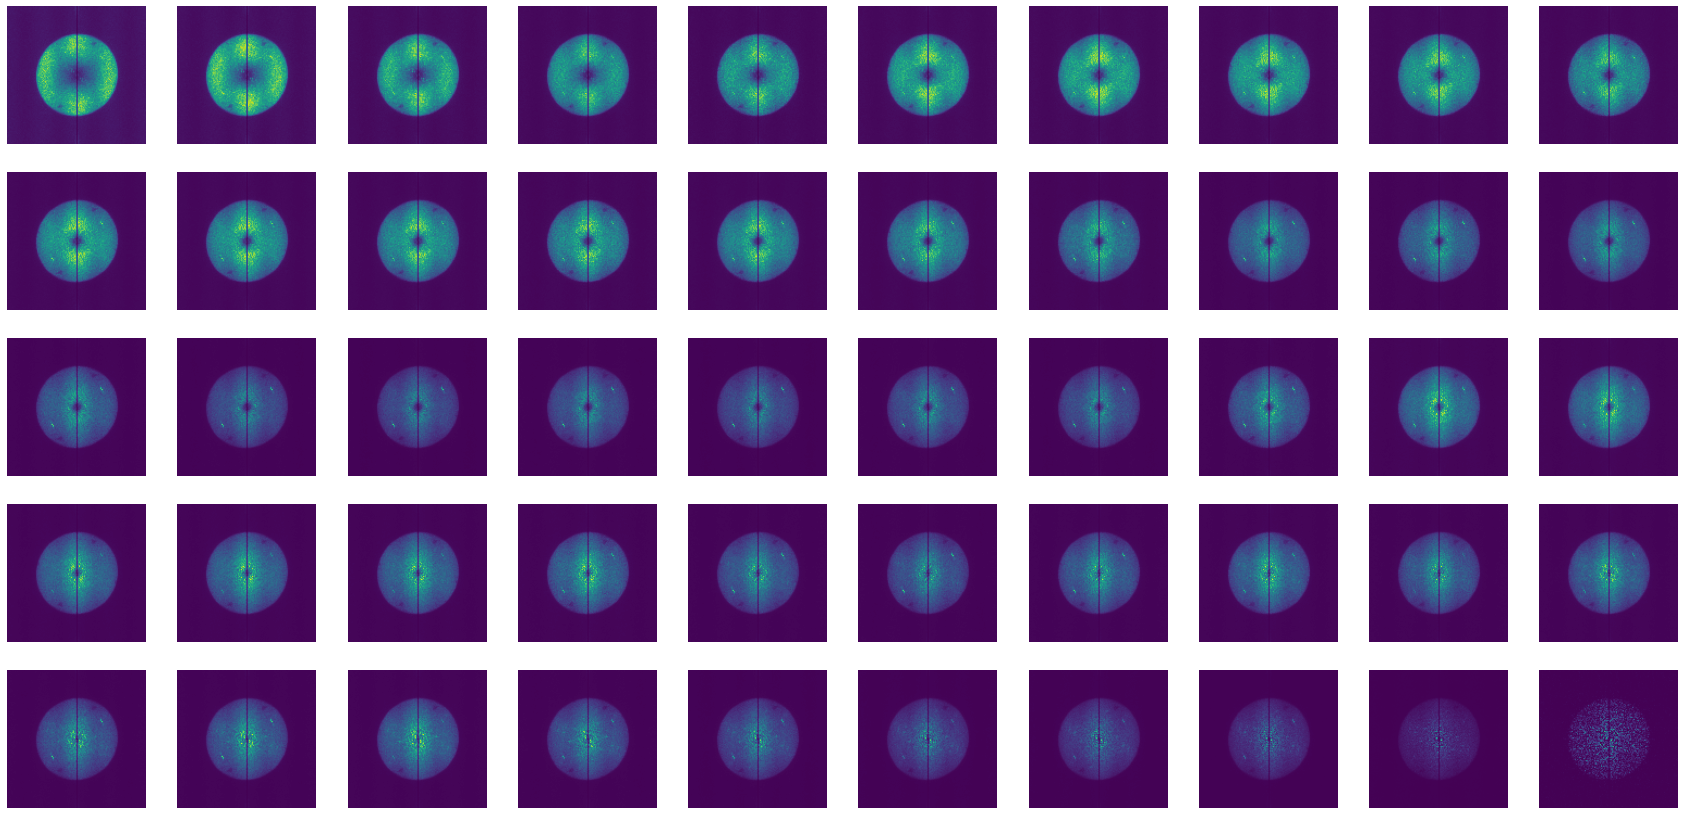

In [14]:
# Process FT images for camera artifacts
fftims = process_FT_ims(fftims0)

# Plot results
fig = plt.figure(figsize=(30,30))
rows = 10
cols = 10

for im in range(len(fftims)):
    fig.add_subplot(rows, cols, im+1)
    plt.imshow(fftims[im])
    plt.axis('off')
    
plt.show()

## Step 2: Calculate the Image Structure Function matrix

The Fourier difference images are azimuthally symmetric because diffusive motion is isotropic. Therefore, we average the intensities over all $\theta$ at each radius $q$ to get the DDM matrix:

$$ D(q,\Delta t) = \langle D(\bar{q}, \Delta t) \rangle_{\theta} $$

In [15]:
def azimuthalAvg(z):
    N = len(z)
    m = int(N/2)
    x,y = np.meshgrid(np.linspace(-1,1,N), np.linspace(-1,1,N))
    r = np.sqrt(x**2 + y**2)
    
    dr = 1/(m-1)
    rbins = np.linspace(dr/2, 1+dr/2, num=m+1)
    
    Zr = []
    Zs = []
    for j in range(0,m):
        bins = np.array(r>=rbins[j])&np.array(r<rbins[j+1])
        
        Zr.append(np.average(z[bins]))
        Zs.append(np.std(z[bins]))
    
    Zr = np.array(Zr)
    Zs = np.array(Zs)
    return Zr,Zs

In [16]:
DDM = np.zeros(shape=(int(Npixels/2),numLags))
std = np.zeros(shape=(int(Npixels/2),numLags))

# Azimuthal averaging of all FT images over all radii q
for dt in range(len(fftims)):
    Zr,Zs = azimuthalAvg(fftims[dt])

    DDM[:,dt] = Zr
    std[:,dt] = Zs

Text(0, 0.5, 'ISF')

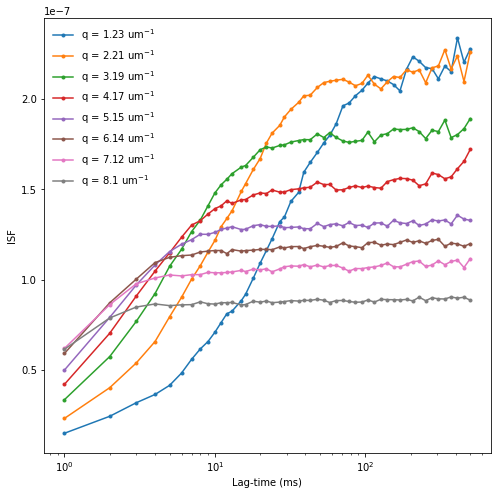

In [17]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.set_xscale("log")
for i in range(4, len(DDM)-30, 4):
    ax.plot(dT, DDM[i], '.-', label='q = %s um$^{-1}$' % str(round(Q[i],2)))
    #ax.errorbar(dT,DDM[i],std[i], label='q = %s um$^{-1}$' % str(round(Q[i],2)))
    
plt.legend(frameon=False)
ax.set_xlabel("Lag-time (ms)")
ax.set_ylabel("ISF")

## Step 3: Analysis of the Image Structure Function

The DDM matrix is also called the Image Structure Function (ISF), and is given by

$$ D(q,\Delta t) = A(q)\left[1 - f(q,\Delta t)\right] + B(q)$$

$A(q)$ is related to the scattering properties of the particles, the coherence properties of the light source, and the properties of the microscope objective.

$B(q)$ accounts for the noise of the detection system and is equal to 2 times the power spectrum of the camera noise (Giavazza *et al.*).

$f(q,\Delta t)$ is the normalized image autocorrelation function, which contains information about the size distribution of the sample:

$$ f(q,\Delta t) = \frac{ \langle \tilde{I}(q, t + \Delta t) \tilde{I}(q, t) \rangle_t}{\langle |\tilde{I}(q, t)|^2 \rangle_t}$$

There are two approaches that we can take at this point:

1. Use the properties of the autocorrelation function to estimate $A(q)$ and $B(q)$, and extract the autocorrelation function directly.

2. Treat $A(q)$ and $B(q)$ as fitting parameters and fit the Image Structure Function using an explicit model for the autocorrelation function.

### Analysis approach 1

Using the properties of the normalized autocorrelation function $f(q,\Delta t)$, we can estimate $A(q)$ and $B(q)$ and extract $f(q,\Delta t)$ directly.

We know that $f(q, \Delta t\rightarrow0)=1$ and $f(q, \Delta t\rightarrow\infty)=0$. Then, for short time lags, the ISF becomes

$$ D(q,\Delta t\rightarrow0) = B(q) $$

and for long time lags, the ISF becomes

$$ D(q,\Delta t\rightarrow\infty) = A(q) + B(q) $$

These correspond to the first and last slices of the DDM matrix that we calculated above, assuming during the measurement that (i). our frametime was adequately fast, such that $\Delta t$ is sufficiently small, and (ii). our movie is long enough such that $\Delta t$ is sufficiently large.

Text(0.5, 0, 'q (um$^{-1}$)')

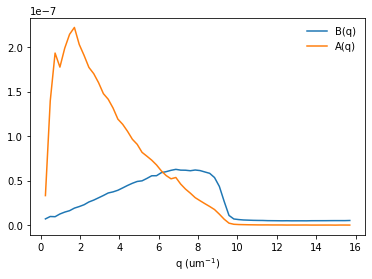

In [18]:
B = DDM[:,0] # Estimate B(q), at short time-lag
A = np.mean(DDM[:,-20:-1],axis=1) - DDM[:,0] # Estimate A(q), at long time-lag

ax = plt.axes()
ax.plot(Q,B,label='B(q)')
ax.plot(Q,A,label='A(q)')
plt.legend(frameon=False)
ax.set_xlabel("q (um$^{-1}$)")

In [19]:
AA = np.transpose(np.tile(np.meshgrid(A),(numLags,1)))
BB = np.transpose(np.tile(np.meshgrid(B),(numLags,1)))

# Extract the autocorrelation functions at each q
f = 1 - ((DDM-BB)/AA)

Text(0, 0.5, 'Autocorrelation')

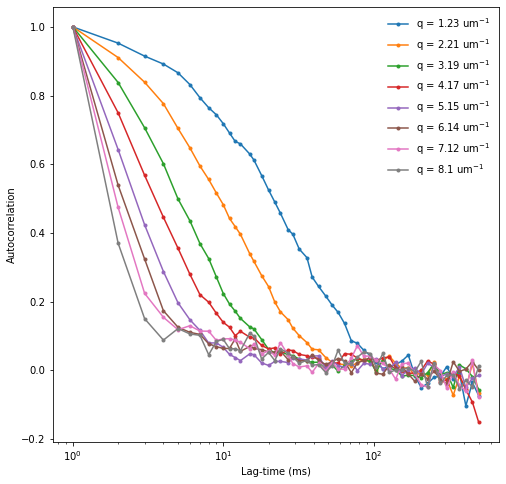

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.set_xscale("log")
plt_inds = range(4, len(DDM)-30, 4)
[ax.plot(dT, f[i], '.-', label='q = %s um$^{-1}$' % str(round(Q[i],2))) for i in plt_inds]

plt.legend(frameon=False)
ax.set_xlabel("Lag-time (ms)")
ax.set_ylabel("Autocorrelation")

At this point, our data is exactly the same as what we would get from multi-angle DLS measurements. We can use all the tools available to analyze the autocorrelation data and get a size distribution, e.g. the CONTIN algorithm.

### Analysis approach 2

Our estimates of the parameters $A(q)$ and $B(q)$ may be inaccurate since they depend on the frame rate and duration of the measurement. Indeed, we see that the plot of $B(q)$ shown above is not flat, as we would expect the noise power spectrum to be, which indicates that our framerate is not high enough to get an accurate estimate. We can take a different approach by treating $A(q)$ and $B(q)$ as fitting parameters. In order to do so, we need an explicit model for the autocorrelation function.

$f(q,\Delta t)$ decays exponentially with lag-time:

$$ f(q,\Delta t) \,\text{ ~ } \exp\left(-\Gamma(q)\,\Delta t \right)$$

For a sample of monodisperse particles diffusing with Brownian motion, $f(q,\Delta t)$ is a single exponential with decay constant  $\Gamma(q) = D q^2$,  where $q$ is the magnitude of the scattering vector and $D$ is the diffusion constant, which is related to the hydrodynamic diameter $d_h$ of the particle by the Stokes-Einstein relation:

$$ D = \frac{k_B T}{3 \pi \eta \,d_h} $$

where $\eta$ is the viscosity of the medium. For a polydisperse sample of diffusing particles, $f(q,\Delta t)$ becomes a multi-exponential function,

$$ f(q,\Delta t) = \int_0^{\infty} G(r) \exp\left(-D(r)q^2 \Delta t \right) dr$$

Where $G(r)$ is the size distribution of the polydisperse sample, which is what we are after.

#### Least squares fitting with `scipy.optimize.curve_fit`

For a first try, and to get good starting parameters for the next steps, we'll fit the curves using scipy.

In [21]:
from scipy.optimize import curve_fit

In [22]:
# Function to fit to
def image_structure_function(t, A, B, gamma):
    return A * (1 - np.exp(-gamma * t)) + B

In [23]:
# Least-squares fit to the explicit model for the image structure function defined above
def LSQ_fit(isf,lags):
    # Crude estimates of initial parameters
    A_init = isf[-1] - isf[0]
    B_init = isf[-1]
    # approx lag time where curve is halfway up to B
    try:
        gamma_init = 1 / lags[np.argwhere(isf > (isf[-1] + isf[0]) / 2)[0][0]]
    except:
        gamma_init = 1
    try:
        fit, cov = curve_fit(image_structure_function, lags, isf, p0=(A_init, B_init, gamma_init))
        cov = np.diagonal(cov)
    except:  # e.g. fit doesn't converge
        fit = [0, 0, 0]
        cov = [0, 0, 0]
    
    return fit, cov

In [24]:
example_idx = 10
data = DDM[example_idx]

fit, cov = LSQ_fit(data, dT)
print(fit) # A, B, gamma

[1.83721643e-07 1.22294725e-08 1.10977962e-01]


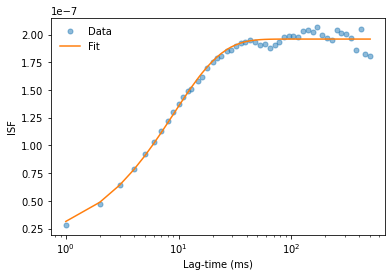

In [25]:
# Checking the fit against the original data
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.set_xscale("log")
ax.plot(dT, data, '.', alpha=0.5, ms=10, label='Data')
ax.plot(dT, image_structure_function(dT, fit[0], fit[1], fit[2]), label='Fit')
plt.legend(frameon=False)
ax.set_xlabel("Lag-time (ms)")
ax.set_ylabel("ISF")
plt.show()

In [26]:
ISF_fits = np.zeros(shape=(len(DDM), 3))
ISF_covs = np.zeros(shape=(len(DDM), 3))
for i in range(len(DDM)):
    isf = DDM[i]
    fit, cov = LSQ_fit(isf,lags)
    ISF_fits[i] = fit
    ISF_covs[i] = cov

/var/folders/5z/167xrdqd2_31xt0v6qbpf5jr0000gn/T/ipykernel_47367/585887002.py:3: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(-gamma * t)) + B
/Users/tkchiang/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


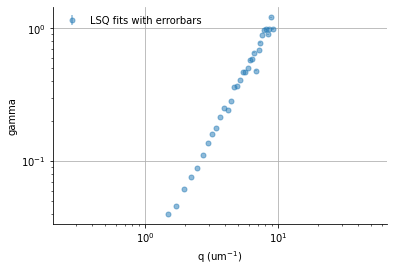

In [27]:
idx = range(5,37)

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
ax.axis('equal')
#ax.plot(Q[idx],ISF_fits.T[2][idx], '.', alpha=0.5, ms=10)
ax.errorbar(Q[idx], ISF_fits.T[2][idx], yerr=ISF_covs.T[2][idx], xerr=None, fmt='.', capsize=None, alpha=0.5, ms=10, label='LSQ fits with errorbars')
plt.grid()
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("q (um$^{-1}$)")
ax.set_ylabel("gamma")
plt.show()

In [28]:
def DiffusionCoefficient2Diameter(DC):
    kB = 1.38e-23
    T = 298
    eta = 1e-3
    diameter = 1e21*kB*T/(3*np.pi*eta*DC)
    return diameter

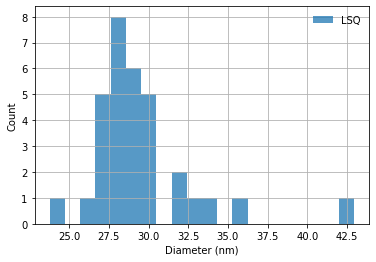

In [29]:
Gamma_LSQ = ISF_fits.T[2][idx]
DCs_LSQ = 1e3*Gamma_LSQ/Q[idx]**2

Diams_LSQ = DiffusionCoefficient2Diameter(DCs_LSQ)

plt.grid()
plt.hist(Diams_LSQ, bins=20, alpha=0.75, label='LSQ')
plt.xlabel('Diameter (nm)')
plt.ylabel('Count')
plt.legend(frameon=False)

Inferred particle size distribution.

In [30]:
# Show average particle size in nm.
# MS2 particles are 26 nm in diameter.
Zavg = np.mean(Diams_LSQ)
Std = np.std(Diams_LSQ)
print("Avg diameter = %d \u00B1 %d" % (Zavg, Std))

Avg diameter = 29 ± 3
